# **2. Usecase: Network Intrusion**
Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.

# **2.1. Data**
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each features, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as su_attempted in the 15th column. Some features are counts, like num_file_creations in the 17th columns. Some others are the number of sent and received bytes.

# **2.2. Clustering without using categorical features**
First, we need to import some packages that are used in this notebook.

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q findspark

In [2]:
!rm spark-2.4.5-bin-hadoop2.7
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!rm spark-2.4.5-bin-hadoop2.7.tgz

rm: cannot remove 'spark-2.4.5-bin-hadoop2.7': No such file or directory


In [12]:
#downloading kddcup data (10%)
!rm kddcup.data.gz
!wget -q http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz
!gunzip kddcup.data.gz
!rm kddcup.data.gz

rm: cannot remove 'kddcup.data.gz': No such file or directory
rm: cannot remove 'kddcup.data.gz': No such file or directory


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

MAX_MEMORY='14g'
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]")\
.config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
        .getOrCreate()

In [0]:
import sys
import re
import time
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
# from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from operator import add
from operator import add
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
import itertools

In [0]:
from pyspark import SparkContext #SparkConf
tempdir="/content/"
path = os.path.join(tempdir, "kddcup.data")
raw_data = spark.sparkContext.textFile(path,3)

In [19]:
spark.sparkContext._conf.get('spark.driver.memory')

'14g'


# **2.2.1. Loading data**
There are two types of features: numerical features and categorical features. Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1:** we don't use the labels in the training phase !!!

**Note 2:** in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

# **Question 1**
Write function parseLine to construct a tuple of (label, vector) for each connection, extract the data that contains only the data points (without label), then print the number of connections.

Where,

* label is the pre-defined label of each connection
* vector is a numpy array that contains values of all features, but the label and the categorial features at index 1,2,3 of each connection. Each vector is a data point.

In [20]:
def parseLine(data):
  print(data.count())
  return data.map(lambda sample: (sample.split(",")))\
              .map(lambda sample: (np.asarray(sample[4:41],dtype='float32'),sample[41:42]))
parsed_raw_data = parseLine(raw_data)

4898431


In [0]:
def separate_train(data):
  return data.map(lambda sample: sample[0])
def separate_labels(data):
  return data.map(lambda sample: sample[1])

In [0]:
train_data = separate_train(parsed_raw_data)
label_data = separate_labels(parsed_raw_data)

# **Question 2**
Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

You can use the following parameters:

* maxIterations=10
* runs=10
* initializationMode="random"
Discuss the result from your figure.

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center. 
We will now use a version of euclidean_distance that assumes the arguments to be numpy arrays, which is really faster, it will come to be useful because this function will be use several million times.

In [0]:
from pyspark.mllib.clustering import KMeans, KMeansModel

clusters = KMeans.train(k=2,rdd=train_data, maxIterations=10, initializationMode="random")

In [0]:
pred = clusters.predict(train_data)

In [0]:
pred = pred.collect()

In [0]:
df_data = train_data.collect()

In [0]:
df = pd.DataFrame(np.asmatrix(df_data,dtype=float))

In [0]:
df['labels'] = pred

In [0]:
df_1 = df[df.labels==1]
df_0 = df[df.labels==0]

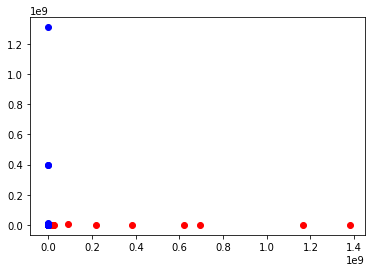

In [31]:
plt.scatter(df_1[:][0],df_1[:][1],c=['red'])
plt.scatter(df_0[:][0],df_0[:][1],c=['blue'])
plt.show()

In [0]:
WSSSE = clusters.computeCost(train_data)

In [33]:
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 6.379370667972552e+18


# **Question 3**
This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Use the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs. What do you think about the result ?

In [34]:
#couldn't use the code given, didn't match up to my tuple.
pred.count(0)

1972793

In [35]:
pred.count(1)

2925638

Haha, there's two clusters but only one point in 1 of the two clusters.

# **2.2.4. Choosing K**
How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of  k . For doing that, we have to build and evaluate models with different values of  k . A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

# **Question 4**
Use the function below to calculate the MSE of each model that is corresponding to each value of  k . Plot the results. From the obtained result, what is the best value for  k  ? Why ?

In [0]:
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    WSSSE = clusters.computeCost(data)
    return WSSSE

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


1.1650532231786496e+18
9.663611878887251e+17
1.0946377851377892e+18
9.904850627709641e+17
9.659916769327931e+17
9.904861382997676e+17
9.659948559396988e+17


Text(0, 0.5, 'clustering score')

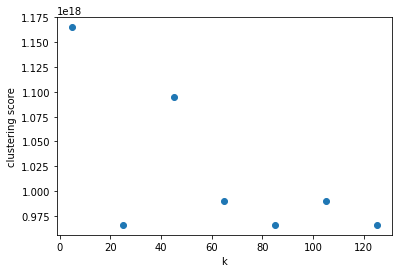

In [37]:
# k: the number of clusters
k_range = range(5, 126, 20)

scores = [clusteringScore(train_data, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

It seems around clusters above 20 give a relevantly constant clustering score. This is our diminishing return.


# **2.2.5 Normalizing features**
K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias.

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation
\begin{align}
normalize_i=\frac{feature_i - \mu_i}{\sigma_i}
\end{align}
Where,
* $normalize_i$  is the normalized value of feature $i$ 
* $\mu_i$ is the mean of feature $i$ 
* $\sigma_i$ is the standard deviation of feature $i$

# **Question 5**
Complete the code below to normalize the data. Print the first 5 lines of the new data.

HINT: If $\sigma_i=0$ then ${normalize}_i = {feature}_i−\mu_i$

In [0]:
def normalizeData(data):
  count = data.count()
  buffer = .00000001
  sum = data.sum()
  mean = sum/count
  std = data.stdev() + buffer
  return data.map(lambda sample: ((sample - mean)/std))

normalizedData_rdd = normalizeData(train_data)

In [39]:
#this is the reason why we have some nan values in the normalized data, if for three columns, the std is 0 because all values are 0, then anything divided by 0 cannot be calculated.
#therefore let's drop these values OR we can add a buffer.
#we may drop because there is no variation in data therefore, has no impact on the importance of the cluster.
train_data.stdev()

array([9.41428368e+05, 6.45005242e+05, 2.39075265e-03, 4.28356602e-02,
       7.21506208e-03, 4.68641538e-01, 7.29851909e-03, 3.50598664e-01,
       3.85642952e+00, 8.25584570e-03, 8.08216762e-03, 3.93798673e+00,
       1.24169913e-01, 8.73627821e-03, 3.54858084e-02, 0.00000000e+00,
       6.38975790e-04, 2.88688836e-02, 2.11869255e+02, 2.45865902e+02,
       3.81817698e-01, 3.82226153e-01, 2.32253261e-01, 2.32659875e-01,
       3.89203542e-01, 8.27127501e-02, 1.40557414e-01, 6.40201763e+01,
       1.05911940e+02, 4.11176840e-01, 1.08536963e-01, 4.80987475e-01,
       4.12604376e-02, 3.81834925e-01, 3.82176612e-01, 2.30940178e-01,
       2.30979104e-01])

# **Question 6**
Using the new data, build different models with different values of $k\in [60,70,80,90,100,110]$ . Evaluate the results by plotting them and choose the best value of $k$.

In [0]:
def clusteringScore(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    WSSSE = clusters.computeCost(data)
    return WSSSE

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


65976410.833136775
62567982.341056265
54991558.74748274
65754378.55422422
64528788.02803522
52235906.63006346


Text(0, 0.5, 'clustering score')

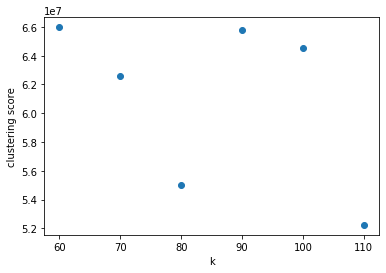

In [41]:
# k: the number of clusters
k_range = range(60, 120, 10)

scores = [clusteringScore(normalizedData_rdd, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

Apparently there's a minimum around 100 clusters...

# **Question 7**
Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


81395788.29539722
64704558.332710035


Text(0, 0.5, 'clustering score')

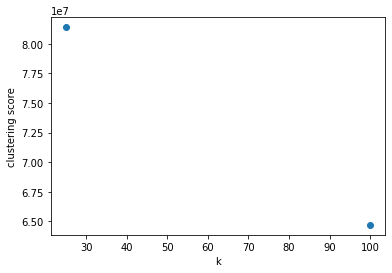

In [42]:
# k: the number of clusters
k_range = [25,100]

scores = [clusteringScore(normalizedData_rdd, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

The variation between the numbers of clusters is something to consider for the error between is relatively small compared to other k clusters. However, it seems more likely a global minimum can be found at 100 k within the scope we've tested, still lower k cluster is still impressive.

# **2.3. Clustering using categorical features**
# **2.3.1 Loading data**
In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering. The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, substraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical features into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in  d -dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice blog post on the problem.

There are two approaches:

* **Approach 1:** mapping one categorial feature to one numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* Approach 2: mapping mapping one categorial feature to multiple numerical features. Basically, a single variable with  n  observations and  d  distinct values, to  d  binary variables with  n  observations each. Each observation indicating the presence (1) or absence (0) of the  dth  binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes
\begin{align}
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
\end{align}
We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.

# **Question 8**
Calculate the number of distinct categorical features value (at index 1,2,3). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

In [0]:
def parseTextCols(data):
  cate_data = data.map(lambda sample: sample.split(",")).map(lambda sample: sample[1:4])
  return cate_data

In [0]:
converted = parseTextCols(raw_data)

In [0]:
types = converted.collect()

In [0]:
#finding the length of the vector needed for this one hot encoding
all_strings = np.ravel(types)
dict_types={}
for a in all_strings:
  if a not in dict_types:
    dict_types[a]=0
  dict_types[a]+=1
all_types = list(dict_types.keys())

In [47]:
all_types.sort()
len(all_types)

84

In [0]:
def make_ohe(data,vec_size,vector):
  ind =  data.map(lambda sample: (all_types.index(sample[0]),all_types.index(sample[1]),all_types.index(sample[2])))
  def make_frame(ind_sample):
    frame = np.zeros(vec_size)
    for x in range(0,3):
      frame[ind_sample[x]] = 1
    return frame
  return ind.map(lambda sample: make_frame(sample))

In [0]:
ohe_cols = make_ohe(converted,len(all_types),all_types)

In [0]:
#the full rdd with normalizedData and categorical, wasn't asked though.
n_and_cate = normalizedData_rdd.join(ohe_cols)

# **2.3.2. Building models**
# **Question 9**
Using the new data, cluster the connections with different values of $k\in [80,90,100,110,120,130,140,150,160]$. Evaluate the results and choose the best value of  k  as previous questions.

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


284561.1990382967
391002.56824084267
422272.4131584193
215658.86214603315
376527.03610817395
236725.81253451682
213298.89448451047
281599.5656401341
264296.6907025046


Text(0, 0.5, 'clustering score')

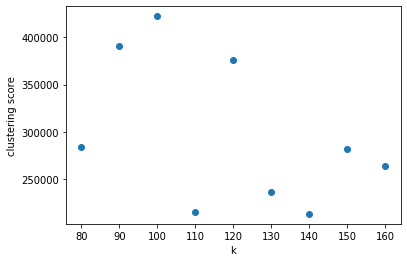

In [56]:
# k: the number of clusters
k_range = range(80, 170, 10)

scores = [clusteringScore(ohe_cols, k) for k in k_range]
for score in scores:
    print(score)
    
# plot results
plt.scatter(k_range, scores)
plt.xlabel('k')
plt.ylabel('clustering score')

Best score is at 140 clusters. It seems above 120, the score is generally decreasing, but considering its scale of improvement at the cost of more clusters, it's to be expected for the score to at some point converge, or even diverge to infinity if at a point adding another cluster actually increases the distance, but for now, we do have some promising local minimums.


# **2.4. Anomaly detection**
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide wheter there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

# **Question 10**
Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

HINT: The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [0]:
def clustering(data, k):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    WSSSE = clusters.computeCost(data)
    print("WSSEE:",str(WSSSE))
    pred_label = clusters.predict(data)
    return (clusters.centers,pred_label)

In [88]:
# k: the number of clusters
k = 25
centers,pred_label = clustering(n_and_cate,k)

/content/spark-2.4.5-bin-hadoop2.7/python/pyspark/mllib/clustering.py:347: UserWarning: The param `runs` has no effect since Spark 2.0.0.
  warnings.warn("The param `runs` has no effect since Spark 2.0.0.")


WSSEE: 81742072.05755892


In [0]:
from math import sqrt
def euclidean_distance(a, b):
    c = a - b
    return np.sqrt(c.T.dot(c))

In [0]:
pred_label = pred_label.collect()

In [0]:
def use_euclidean_distance(data,centers,pred):
  return data.zipWithIndex().map(lambda sample: (euclidean_distance(sample[0]),centers[pred[sample[1]]]))

In [0]:
inner_prod = use_euclidean_distance(n_and_cate,centers,pred_label)

In [0]:
inner_prod = inner_prod.join(n_and_cate)

In [0]:
sorted_data = n_and_cate.sortByKey(ascending=False)

In [0]:
count = sorted_data.count()

In [0]:
one_t_percentage_furthest = sorted_data.zipWithIndex().filter(lambda sample: sample[1] > count*.001)

In [110]:
one_t_percentage_furthest.take(1)

[]

I believe the best k-cluster is 25 because it is the first k-cluster during our looping for larger k-clusters, there was a significant drop in score. The scores for larger k-clusters are less but they are pretty consistent and probably converge; therefore, diminishing returns is not desirable. I also switched to using both the one-hot-encoded categorical data and the numerical data together for a better model.
The plot I made is a line plot of the euclidean distance colored by their respected clusters, by this we can clearly see where outliers are most prominent in which cluster as well as a general idea of the distribution of the points in terms of euclidean distance.